In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [8]:
def plot(dataset):
    # Load the CSV data
    data = pd.read_csv('../acc_rate_csvs/' + dataset + '.csv')

    # Group by method and calculate mean and standard deviation for accuracy
    grouped = data.groupby('method')['acc'].agg(['mean', 'std']).reset_index()

    # Plotting
    plt.figure(figsize=(5, 2))

    # Plot mean accuracy
    plt.errorbar(grouped['mean'], grouped['method'], xerr=grouped['std'], fmt='o', capsize=5, capthick=2, elinewidth=2, color='b', label='Mean Accuracy ± Std Dev')

    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Add labels and title
    plt.ylabel('Method')
    plt.xlabel('Accuracy')
    plt.title('Mean Accuracy and Standard Deviation of Each Method: ' + dataset)
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

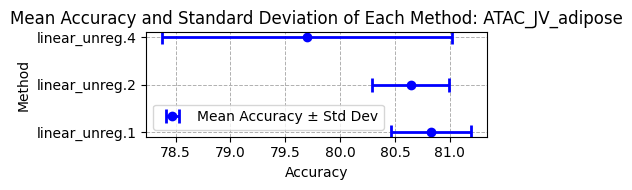

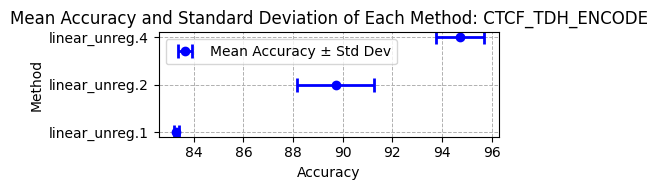

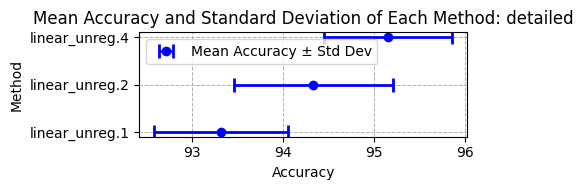

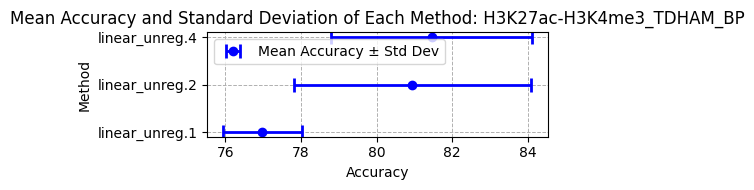

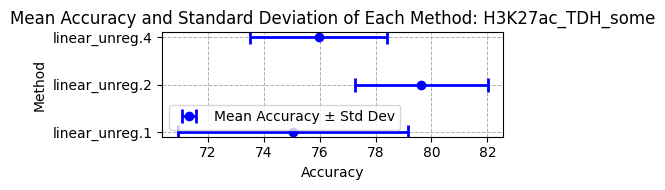

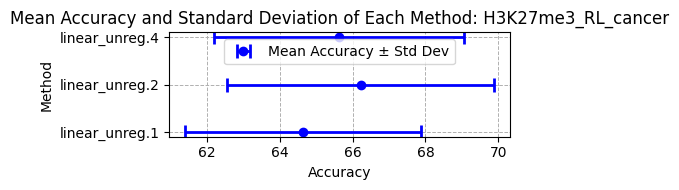

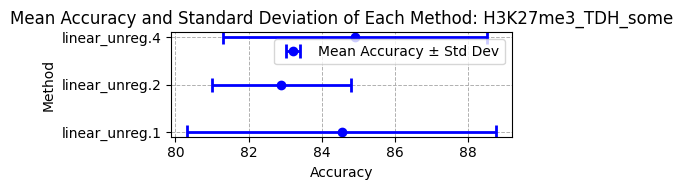

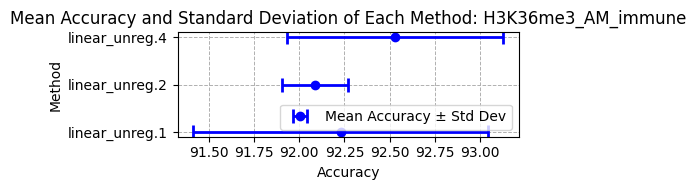

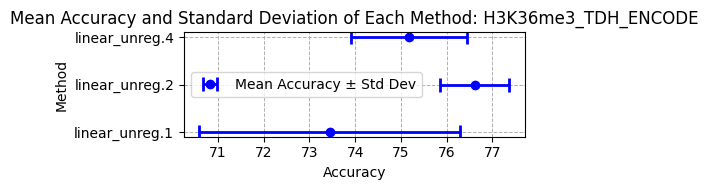

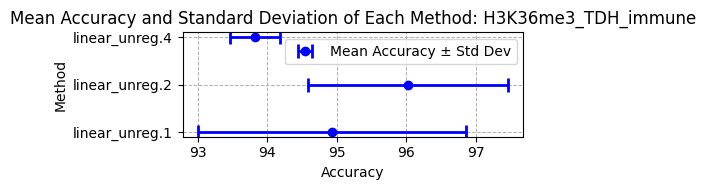

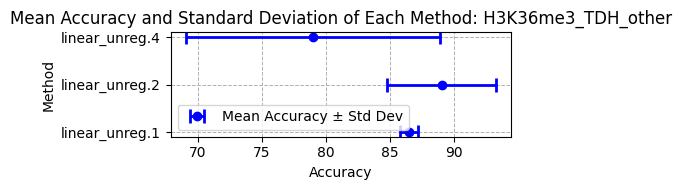

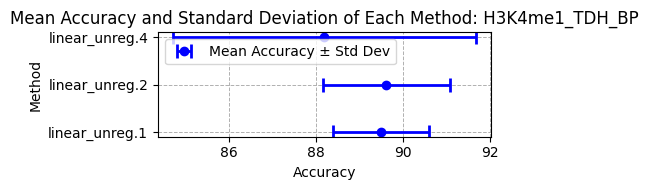

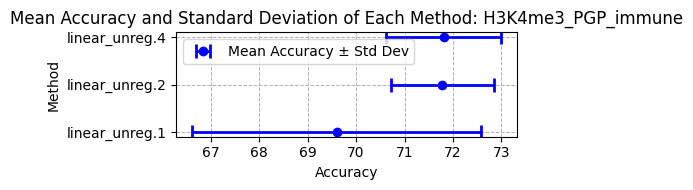

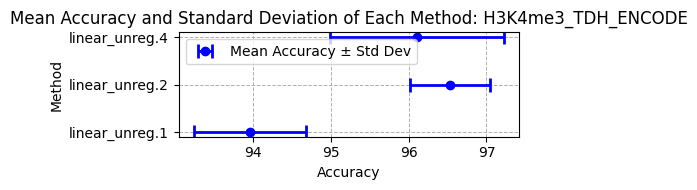

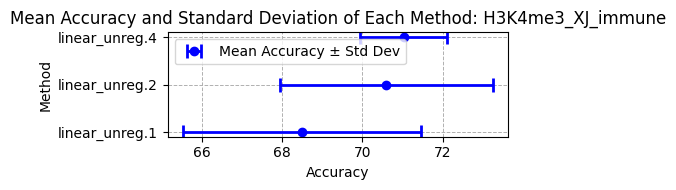

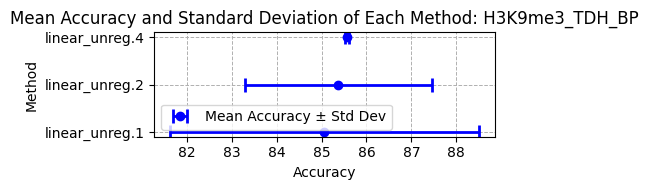

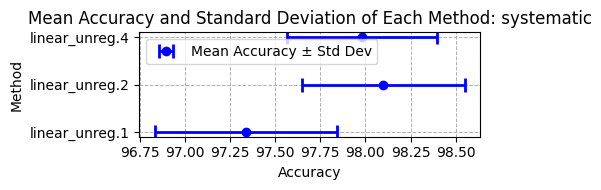

In [9]:
folder_path = 'C:/Users/nguye/Downloads/ML_ChangepointDetection/training_data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
for dataset in datasets:
    plot(dataset)